In [1]:
import pandas as pd
import numpy as np
import sklearn

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')

In [2]:
from sklearn.model_selection import KFold, GridSearchCV, cross_validate, ParameterGrid
from sklearn.feature_selection import RFECV
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [3]:
def information(rtd):
    info = pd.DataFrame({'Column': rtd.columns})
    info['unique'] = [len(rtd[c].unique()) for c in rtd.columns]
    info['type'] = [rtd[c].dtype for c in rtd.columns]
    info['isNull'] = [sum(rtd[c].isnull()) for c in rtd.columns]
    return info.set_index('Column')

In [4]:
loc_train = 'raw_data\\train.csv'
loc_test = 'raw_data\\test.csv'

target = 'Survived'
learning = 'Classification' # 'Regression' or 'Classification'
evaluation = 'accuracy'
Id = 'PassengerId'

raw_train_data = pd.read_csv(loc_train)
y = raw_train_data[target]
raw_train_data = raw_train_data.drop(target, axis=1)
raw_test_data = pd.read_csv(loc_test)
raw_train_data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
info = information(raw_train_data)
info

,unique,type,isNull
Column,,,
PassengerId,891,int64,0
Pclass,3,int64,0
Name,891,object,0
Sex,2,object,0
Age,89,float64,177
SibSp,7,int64,0
Parch,7,int64,0
Ticket,681,object,0
Fare,248,float64,0


In [6]:
info[info.isNull>0]

,unique,type,isNull
Column,,,
Age,89,float64,177
Cabin,148,object,687
Embarked,4,object,2


In [7]:
for col in info[(info.type == 'object') & (info.isNull>0)].index:
    print (col, '\t', raw_train_data[col].unique())

Cabin 	 [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']
Embarked 	 ['S' 'C' 'Q' nan]


In [8]:
R = raw_train_data.copy()
R['y'] = y



In [9]:
Z = pd.concat([raw_train_data, raw_test_data])

In [10]:
imputer = KNNImputer(n_neighbors= 7, weights= 'distance')
scaler = PowerTransformer()

Z['Cabin'] = Z.Cabin.apply(lambda c: c[0] if type(c)!= float else c)
Z['hasCabin'] = Z.Cabin.notnull().astype('int')

Z['Title'] = Z['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
titlefrq = Z.Title.value_counts() < 10
Z['Title'] = Z['Title'].apply(lambda s: 'Misc' if titlefrq.loc[s] == True else s)


Z = Z.drop(['PassengerId', 'Name', 'Ticket'], 
                 axis = 1)

In [11]:
float_cols  = Z.select_dtypes(exclude= 'object').columns.tolist() 
object_cols = Z.select_dtypes(include= 'object').columns.tolist() 
two_unique = [c for c in object_cols if len(Z[c].unique())==2]

ZD = pd.get_dummies(Z, columns = two_unique, drop_first=True)
ZD = pd.get_dummies(ZD)

ZD[float_cols] = StandardScaler().fit_transform(ZD[float_cols])

imputer = imputer.fit(ZD)
imputed = imputer.transform(ZD)
ZD = pd.DataFrame(imputed, columns= ZD.columns)

scaler = scaler.fit(ZD[float_cols])
ZD[float_cols] = scaler.transform(ZD[float_cols])

ZD.shape


(1309, 23)

In [12]:
size_train = raw_train_data.shape[0]

train_X = ZD.iloc[:size_train]
test_X = ZD.iloc[size_train:]

T = train_X.copy()
T['y'] = y
T.head()

,Pclass,Age,SibSp,Parch,Fare,hasCabin,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,y
0,0.891908,-0.517115,1.344582,-0.553061,-0.994604,-0.539377,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1,-1.388945,0.601072,1.344582,-0.553061,1.536208,1.853992,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,0.891908,-0.209352,-0.680702,-0.553061,-0.924307,-0.539377,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
3,-1.388945,0.412967,1.344582,-0.553061,1.299924,1.853992,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
4,0.891908,0.412967,-0.680702,-0.553061,-0.911455,-0.539377,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


In [13]:
print (raw_train_data.shape, train_X.shape)
print (raw_test_data.shape, test_X.shape)

(891, 11) (891, 23)
(418, 11) (418, 23)


In [14]:
information(T)

,unique,type,isNull
Column,,,
Pclass,3,float64,0
Age,170,float64,0
SibSp,7,float64,0
Parch,7,float64,0
Fare,248,float64,0
hasCabin,2,float64,0
Sex_male,2,float64,0
Cabin_A,2,float64,0
Cabin_B,2,float64,0


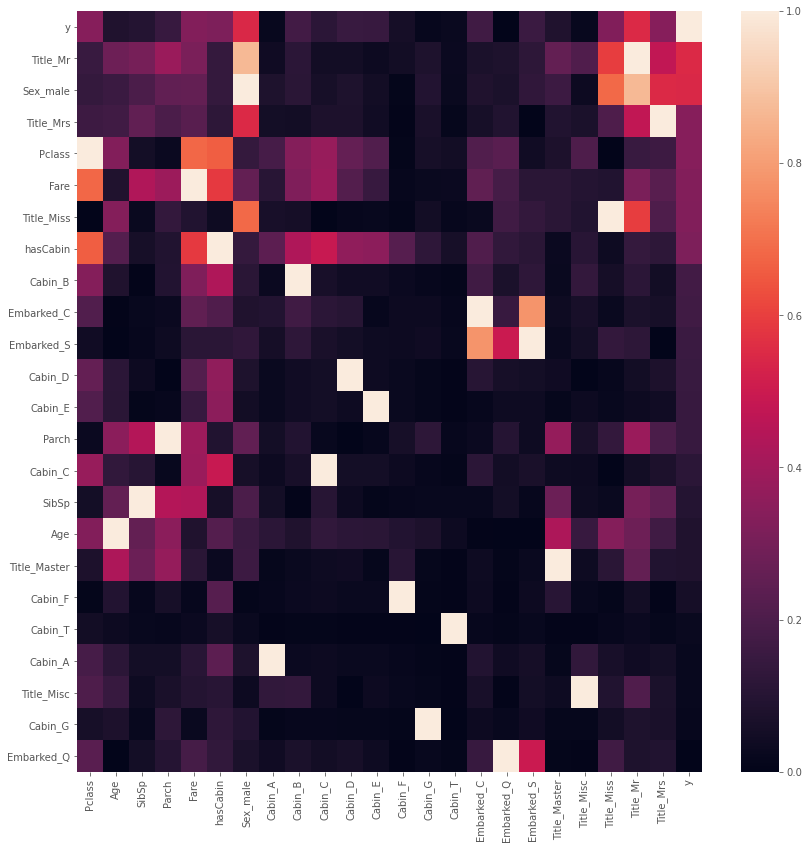

In [15]:
Corr = T.corr().abs().sort_values('y', ascending=False)
plt.figure(figsize=(14, 14))
sns.heatmap(Corr)
plt.show()

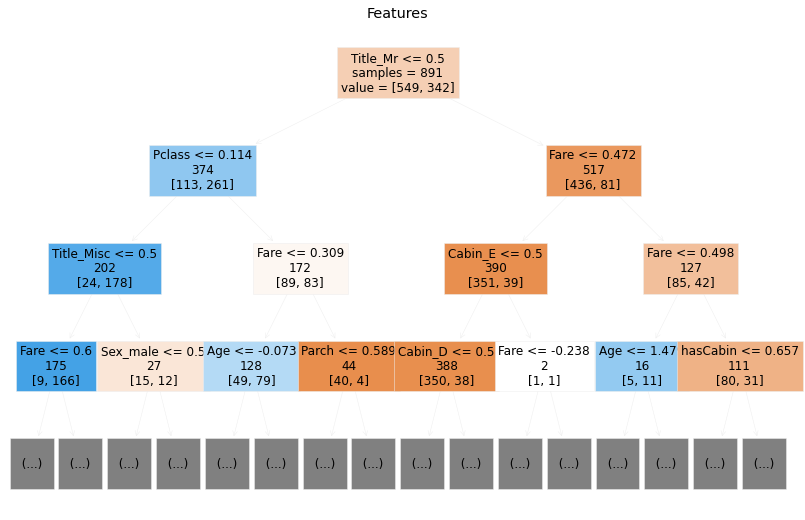

In [16]:
if learning == 'Regression':
    dt = DecisionTreeRegressor()
else:
    dt = DecisionTreeClassifier()
dt.fit(train_X, y)
plt.figure(figsize = (14, 9))
plot_tree(dt, 
          max_depth = 3, 
          filled = True, 
          fontsize=12, 
          label='root', 
          impurity=False, 
          feature_names=train_X.columns
         )
plt.title('Features')
plt.show()

In [17]:
if learning == 'Regression':
    model = DecisionTreeRegressor()
else:
    model = DecisionTreeClassifier()
    
Fstack = RFECV(model, scoring = evaluation)

In [18]:
Fstack.fit(train_X, y)

RFECV(estimator=DecisionTreeClassifier(), scoring='accuracy')

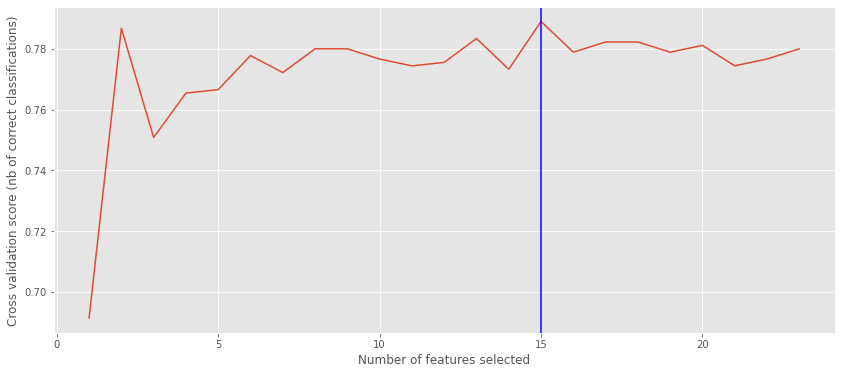

In [19]:
rfescore = Fstack.grid_scores_
plt.figure(figsize=(14, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfescore) + 1), rfescore)
plt.axvline(Fstack.n_features_, color='blue')
# plt.xticks(list(plt.xticks()[0]) + [Fstack.n_features_])
plt.show()

In [20]:
Fstack.n_features_

15

In [21]:
Fstack.grid_scores_.mean()

0.772942008061941

In [22]:
cc = Fstack.get_support()

In [36]:
cimp = train_X.columns.tolist()
# cimp = train_X.columns[cc].tolist()
print (cimp)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'hasCabin', 'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs']


In [24]:
train_csv = train_X[cimp]
test_csv = test_X[cimp]

train_csv[target] = y
test_csv[Id] = raw_test_data[Id].tolist()
train_csv[Id] = raw_train_data[Id].tolist()

In [25]:
from sklearn.neighbors import KNeighborsClassifier
aval_model = KNeighborsClassifier(n_neighbors=3)

it = np.array([0]*size_train + [1]*raw_test_data.shape[0])
aval_model.fit(ZD, it)
ip = aval_model.predict(ZD)
sklearn.metrics.accuracy_score(it, ip)

0.7769289533995416

In [26]:
ival = ip[:size_train]==1
sum(ival)

85

In [34]:
y[ival].mean()

0.3058823529411765

In [35]:
y.mean()

0.3838383838383838

In [27]:
probs = aval_model.predict_proba(ZD[:size_train])[:, 1]

In [28]:
val_csv = train_csv[ival]
train_csv = train_csv[~ival]

In [30]:
train_csv.to_csv('data\\train.csv', index=False)
test_csv.to_csv('data\\test.csv', index=False)
val_csv.to_csv('data\\val.csv', index=False)

In [31]:
test_csv.head()#.transpose()

,Pclass,Age,SibSp,Parch,Fare,hasCabin,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,PassengerId
891,0.891908,0.380839,-0.680702,-0.553061,-0.934192,-0.539377,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,892
892,0.891908,1.127163,1.344582,-0.553061,-1.021027,-0.539377,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,893
893,-0.663297,1.917269,-0.680702,-0.553061,-0.747817,-0.539377,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,894
894,0.891908,-0.135219,-0.680702,-0.553061,-0.849225,-0.539377,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,895
895,0.891908,-0.517115,1.344582,1.730336,-0.505513,-0.539377,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,896
